***
# PREVISÃO DE VENDAS - REDE DE DROGARIAS 
## PARTE II - IMPLEMENTANDO OS MODELOS DE MACHINE LEARNING
***

## CONTEXTUALIZAÇÃO DO PROJETO:
***

O CFO da rede de drogarias solicitou uma previsão de vendas com o objetivo de obter informações precisas sobre o desempenho das lojas da rede e determinar o valor do investimento necessário para reformar cada uma das lojas. Utilizaremos um conjunto de dados históricos de vendas diárias que abrangem um período de dois anos e meio para fazer previsões de vendas diárias para as 1.115 lojas da rede localizadas em diferentes partes da Alemanha para os próximos 42 dias. Essas previsões fornecerão informações sobre o valor total das vendas esperadas em cada loja, bem como como essas vendas serão distribuídas diariamente. O objetivo final é fornecer informações confiáveis que permitam que a empresa tome decisões informadas sobre o investimento em reformas nas lojas.

**Premissas do negócio:**
    
    1. Foram consideradas para a previsão apenas as lojas que possuem o valor de vendas superior a 0 na base de dados.

    2. Os dias em que as lojas estavam fechadas foram descartadas na realização da previsão.
   

*O contexto, pessoas e perguntas são completamente fictícios.* O dataset utilizado para o projeto está disponível no [Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales/data).

**SUMÁRIO EXECUTIVO**
**PARTE II**


**1. IMPORTS DE LIBRARIES E DATASET**

**2. SPLIT**

**3. PREPARAÇÃO DOS DADOS**
    
**4. IMPLEMENTANDO OS MODELOS DE MACHINE LEARNING**
    
    4.1 Média - Modelo Baseline
    4.2 Linear Regression
    4.3 Random Forest Regressor
    4.4 XGboost Regressor
    4.5 Comparando as performances
    
**5. CROSS VALIDATION**
    
    5.1 Média - Modelo Baseline
    5.2 Linear Regression
    5.3 Random Forest Regressor
    5.4 XGboost Regressor
    5.5 Comparando as performances

**6. XGBOOST REGRESSOR**
    
    6.1 XGBoost Hyperparameter Tuning: Random Search
    6.2 Modelo final
    6.3 Traduação e interpretação do erro
    6.4 Bussiness performance
    6.5 Performance Total
    6.6 Machine Learning Performance
    
**3. CONCLUSÃO DO PROJETO E PERSPECTIVAS**

# LOADING LIBRARIES

In [ ]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,  FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
import random
import xgboost as xgb
import pickle
plt.rcParams['figure.figsize'] = [12, 5]

# FUNÇÕES AUXILIARES

In [6]:
def day_week_month_transform(df):
    # Verifica se as colunas necessárias estão presentes no DataFrame
    required_cols = ['DayOfWeek', 'Month', 'Day', 'WeekOfYear']
    missing_cols = set(required_cols) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

    # Transforma o dia da semana em coordenadas polares para preservar a ordem circular
    df['DayOfWeek_sin'] = df['DayOfWeek'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
    df['DayOfWeek_cos'] = df['DayOfWeek'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

    # Transforma o mês em coordenadas polares para preservar a ordem circular
    df['Month_sin'] = df['Month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
    df['Month_cos'] = df['Month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

    # Transforma o dia do mês em coordenadas polares para preservar a ordem circular
    df['Day_sin'] = df['Day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
    df['Day_cos'] = df['Day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
    # Transforma a semana do ano em coordenadas polares para preservar a ordem circular
    df['WeekOfYear_sin'] = df['WeekOfYear'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
    df['WeekOfYear_cos'] = df['WeekOfYear'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

    return df

In [7]:
def handle_missing_values(df):
    """
    Realiza imputação de valores ausentes em um DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        O DataFrame a ser tratado.

    Retorna:
    --------
    pandas.DataFrame
        O DataFrame com valores ausentes imputados.
    """
    if not all(col in df.columns for col in [
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'
    ]):
        raise ValueError(
            "As colunas 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval devem estar presentes no DataFrame."
        )

    # Imputação para a coluna 'CompetitionOpenSinceMonth' com a estratégia de moda
    imputer = SimpleImputer(strategy='most_frequent')
    df.loc[:, 'CompetitionOpenSinceMonth'] = imputer.fit_transform(
        df[['CompetitionOpenSinceMonth']])

    # Imputação para a coluna 'CompetitionOpenSinceYear' com a estratégia de moda
    imputer = SimpleImputer(strategy='most_frequent')
    df.loc[:, 'CompetitionOpenSinceYear'] = imputer.fit_transform(
        df[['CompetitionOpenSinceYear']])

    # Imputação para a coluna 'CompetitionDistance' com a estratégia de mediana
    imputer = SimpleImputer(strategy='median')
    df.loc[:, 'CompetitionDistance'] = imputer.fit_transform(
        df[['CompetitionDistance']])

    # Substituição de valores ausentes por zero
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna(0, inplace=True)

    return df

In [8]:
def ml_errors(model_name, y_true, y_pred):
    """
    Calcula as métricas de erro do modelo fornecido.

    Parâmetros:
    -----------
    model_name : str
        Nome do modelo.
    y_true: list, array
        Valores reais do target.
    y_pred: list, array
        Valores previstos pelo modelo.

    Retorna:
    --------
    df: pd.DataFrame
        DataFrame com as métricas de erro calculadas.
    """
    # Calcula métricas de erro
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Cria DataFrame com as métricas de erro
    df = pd.DataFrame(
        {
            'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])

    return df

In [10]:
def cross_validation(x_training, model_name, model, kfold=5, verbose=False):
    """
    Realiza a validação cruzada do modelo especificado usando os dados de treinamento fornecidos.

    Parâmetros:
    -----------
    x_training : DataFrame
        Dados de treinamento.
    model_name : str
        Nome do modelo.
    model : object
        Modelo a ser avaliado.
    kfold : int, default=5
        Número de folds a serem usados na validação cruzada.
    verbose : bool, default=False
        Define o nível de verbose da função. Se False, não há mensagens de progresso.
        Se True, apenas as mensagens de progresso serão exibidas.

    Retorna:
    --------
    DataFrame
        Um dataframe com as métricas de desempenho médias e seus desvios padrão.
    """

    results = []
    tscv = TimeSeriesSplit(n_splits=kfold)

    for train_index, val_index in tscv.split(x_training):
        if verbose:
            print('\nKFold Number: {}'.format(kfold))

        # training dataset
        xtraining = x_training.iloc[train_index].drop(
            ['Date', 'Sales'], axis=1)
        ytraining = x_training.iloc[train_index]['Sales']

        # validation dataset
        xvalidation = x_training.iloc[val_index].drop(
            ['Date', 'Sales'], axis=1)
        yvalidation = x_training.iloc[val_index]['Sales']

        # model
        # Scaling
        rs = RobustScaler()

        # StoreType - OneHotEncoder
        ohe = OneHotEncoder()

        # Assortment - Ordinal Encoder
        oe = OrdinalEncoder(categories=[['a', 'b', 'c']], dtype='int')

        # Transformations
        transformations = ColumnTransformer(
            [('robust-scaler', rs,
              ['CompetitionDistance', 'CompetitionTimeMonth', 'Promo2Since']),
             ('ohe', ohe, ['StoreType']), ('ordinal_assortment', oe, ['Assortment'])],
            remainder='passthrough')

        pipeline = Pipeline([('preprocessing', transformations),
                             ('model', model)])

        m = pipeline.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_errors(model_name, np.expm1(yvalidation), np.expm1(yhat))
        results.append(m_result)
        modelling_result = pd.concat(results)

        mae = modelling_result['MAE'].mean()
        mape = modelling_result['MAPE'].mean()
        rmse = modelling_result['RMSE'].mean()

        mae_std = modelling_result['MAE'].std()
        mape_std = modelling_result['MAPE'].std()
        rmse_std = modelling_result['RMSE'].std()

    return pd.DataFrame(
        {
            'Model Name': model_name,
            'MAE CV': [mae, mae_std],
            'MAPE CV': [mape, mape_std],
            'RMSE CV': [rmse, rmse_std]
        },
        index=['mean', 'std'])

# LOADING DATASET

In [12]:
# Dados históricos, incluindo a target vendas filtrados para lojas abertas
df = pd.read_csv('../data/processed/data_filtering.csv',index_col=0, parse_dates=['Date'], low_memory=False)

# SPLIT

In [13]:
# Conjunto de dados sem transformações
df1 = df.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,YearWeek,Season
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.00,2010.00,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,Summer
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.00,2011.00,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,Summer
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer


In [14]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'YearWeek', 'Season'],
      dtype='object')

In [15]:
# Transformações
# Log variável resposta
df1['Sales'] = np.log1p(df1['Sales'])

df1 = day_week_month_transform(df1)

In [16]:
# Define a data limite para separar entre treino e teste
limite_data = '2015-06-19'

# Separa os dados em treino e teste
# Treino
X_train = df1[df1['Date'] < limite_data]
y_train = X_train['Sales']

# Teste
X_test = df1[df1['Date'] >= limite_data]
y_test = X_test['Sales']

# PREPARAÇÃO DOS DADOS

In [17]:
X_train = X_train.copy()
X_test = X_test.copy()

In [18]:
# Preenchendo missing values
X_train = handle_missing_values(X_train)
X_test = handle_missing_values(X_test)

In [19]:
# Convertendo tipos de dados
X_train['CompetitionOpenSinceMonth'] = X_train['CompetitionOpenSinceMonth'].astype(int)
X_train['CompetitionOpenSinceYear'] = X_train['CompetitionOpenSinceYear'].astype(int)
X_train['Promo2SinceWeek'] = X_train['Promo2SinceWeek'].astype(int)
X_train['Promo2SinceYear'] = X_train['Promo2SinceYear'].astype(int)

# Convertendo tipos de dados em X_test
X_test['CompetitionOpenSinceMonth'] = X_test['CompetitionOpenSinceMonth'].astype(int)
X_test['CompetitionOpenSinceYear'] = X_test['CompetitionOpenSinceYear'].astype(int)
X_test['Promo2SinceWeek'] = X_test['Promo2SinceWeek'].astype(int)
X_test['Promo2SinceYear'] = X_test['Promo2SinceYear'].astype(int)

In [20]:
# Adicionando features

# Competition
X_train['CompetitionSince'] = pd.to_datetime(
   X_train['CompetitionOpenSinceYear'].astype(
        str) + '-' + X_train['CompetitionOpenSinceMonth'].astype(str) + '-01'
)

X_train['CompetitionTimeMonth'] = (
    (X_train['Date'] - X_train['CompetitionSince']) / np.timedelta64(1, 'M')).astype(int)

# Promo2 Since
promo2since = ((X_train['Year'] - X_train['Promo2SinceYear']) * 12 +
               (X_train['WeekOfYear'] - X_train['Promo2SinceWeek']) * 0.230137)
X_train['Promo2Since'] = promo2since.clip(lower=0) * X_train['Promo2']

# Adicionando features

# Competition
X_test['CompetitionSince'] = pd.to_datetime(
   X_test['CompetitionOpenSinceYear'].astype(
        str) + '-' + X_test['CompetitionOpenSinceMonth'].astype(str) + '-01'
)

X_test['CompetitionTimeMonth'] = (
    (X_test['Date'] - X_test['CompetitionSince']) / np.timedelta64(1, 'M')).astype(int)

# Promo2 Since
promo2since = ((X_test['Year'] - X_test['Promo2SinceYear']) * 12 +
               (X_test['WeekOfYear'] - X_test['Promo2SinceWeek']) * 0.230137)
X_test['Promo2Since'] = promo2since.clip(lower=0) * X_test['Promo2']

# SPLIT + SELEÇÃO DE FEATURES

## Features rankeadas como relevantes pelo Boruta

In [21]:
# Features rankeadas como relevantes pelo Boruta
cols_selected_boruta = [['Store', 'Promo', 'CompetitionDistance', 'CompetitionTimeMonth',
       'Promo2Since', 'DayOfWeek_cos']]

In [22]:
cols_selected = ['Store', 'StoreType', 'CompetitionDistance', 'CompetitionTimeMonth', 'DayOfWeek_sin', 'DayOfWeek_cos',
                 'Assortment', 'Promo2', 'Promo2Since', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'WeekOfYear_sin',
                 'WeekOfYear_cos']

feature_add = ['Date', 'Sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend(feature_add)

In [23]:
# Colunas selecionadas pelo Boruta
X_train_b = X_train[cols_selected] 
X_test_b = X_test[cols_selected]

# time series preparation
X_training = X_train[cols_selected_full]

# PRÉ-PROCESSAMENTO DOS DADOS

In [24]:
# Scaling
rs = RobustScaler()

# StoreType - OneHotEncoder
ohe = OneHotEncoder()

# Assortment - Ordinal Encoder
oe = OrdinalEncoder(categories=[['a', 'b', 'c']], dtype='int')

# Transformations
transformations = ColumnTransformer(
    [('robust-scaler', rs,
      ['CompetitionDistance', 'CompetitionTimeMonth', 'Promo2Since']),
     ('ohe', ohe, ['StoreType']), ('ordinal_assortment', oe, ['Assortment'])],
    remainder='passthrough')

In [ ]:
# Dump the transformers using pickle
with open('transformations.pkl', 'wb') as f:
    pickle.dump(transformations, f)

# IMPLEMENTANDO OS MODELOS DE MACHINE LEARNING

1. Média
2. Linear Regression
3. Linear Regression Regularized
4. Random Forest Regressor
5. XGBoost Regressor

## Média

- Vamos utilizar a média como comparação para os modelos de machine learning.

In [25]:
x_df = X_test_b.copy()
x_df['Sales'] = y_test.copy()

In [26]:
# Predições médias
mean_sales = x_df[['Store',
                   'Sales']].groupby('Store').mean().reset_index().rename(
                       columns={'Sales': 'Predictions'})
x_df2 = pd.merge(x_df, mean_sales, how='left', on='Store')

# Estimativa baseline
yhat_baseline = x_df2['Predictions']

In [27]:
baseline_result = ml_errors('Average', np.expm1(y_test), np.expm1(yhat_baseline))

In [28]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average,1354.80,0.21,1835.14


## Linear regression

In [29]:
# Modelo
modelo = LinearRegression()

pipeline_lr = Pipeline([('preprocessing', transformations), ('modelo', modelo)])

lr = pipeline_lr.fit(X_train_b, y_train)

# Predição
yhat_lr = lr.predict(X_test_b)

# Performance
lr_result = ml_errors('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2096.45,0.33,2929.92


## Linear Regression Regularized

In [30]:
# modelo com mais colunas
# Modelo
modelo2 = Lasso(alpha=0.01)
pipeline_lrr = Pipeline([('preprocessing', transformations),
                      ('modelo2', modelo2)])

lrr = pipeline_lrr.fit(X_train_b, y_train)

# Predição
yhat_lrr = lrr.predict(X_test_b)

# Performance
lrr_result = ml_errors('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,2131.90,0.33,3014.62


- Os erros da linear regression e linear regression regularized são superiores aos erros da média.
- Portanto, podemos considerar que os dados não apresentam um comportamento linear. Muito provavelmente modelos lineares não serão suficientes para aprender o padrão de comportamento dos dados.

## Random Forest Regressor

In [31]:
# Modelo 
modelo3 = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
pipeline_rf = Pipeline([('preprocessing', transformations),
                      ('modelo3', modelo3)])

rf = pipeline_rf.fit(X_train_b, y_train)

# Predição
yhat_rf = rf.predict(X_test_b)

# Performance
rf_result = ml_errors('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,826.18,0.12,1213.59


## XGBoost Regressor

In [45]:
# Modelo
modelo4 = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=1000,
    eta=0.01,  # learning_rate
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9)

pipeline_xgb = Pipeline([('preprocessing', transformations),
                      ('modelo4', modelo4)])

model_xgb = pipeline_xgb.fit(X_train_b, y_train)

# Predição
yhat_xgb = model_xgb.predict(X_test_b)

# Performance
xgb_result = ml_errors('XGBoost Regressor', np.expm1(y_test),
                       np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,953.37,0.14,1391.75


## Comparando as performances dos modelos

In [46]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,826.18,0.12,1213.59
0,XGBoost Regressor,953.37,0.14,1391.75
0,Average,1354.80,0.21,1835.14
0,Linear Regression,2096.45,0.33,2929.92
0,Linear Regression Regularized,2131.90,0.33,3014.62


# CROSS VALIDATION

## Linear Regression

In [48]:
lr_cv = cross_validation(X_training, 'Linear Regression',
                         LinearRegression(), kfold=5, verbose=True)
lr_cv


KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
mean,Linear Regression,2204.71,0.36,3041.01
std,Linear Regression,113.73,0.01,184.58


## Linear Regression Regularized

In [49]:
lss_cv = cross_validation(X_training, 'Linear Regression Regularized',
                         Lasso(), kfold=5, verbose=True)
lss_cv


KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
mean,Linear Regression Regularized,2248.00,0.37,3133.63
std,Linear Regression Regularized,90.11,0.01,167.91


## Random Forest Regressor

In [50]:
rf_cv = cross_validation(X_training, 'Random Forest Regressor',
                         RandomForestRegressor(), kfold=5, verbose=True)
rf_cv


KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
mean,Random Forest Regressor,1438.87,0.23,2089.74
std,Random Forest Regressor,164.40,0.02,245.91


## XGBoost Regressor

In [51]:
xgb_cv = cross_validation(
    X_training, 'XGBoost',
    xgb.XGBRegressor(objective='reg:squarederror',
                     n_estimators=1000,
                     eta=0.01,
                     max_depth=10,
                     subsample=0.7,
                     colsample_bytree=0.9), kfold=5, verbose=True)
xgb_cv


KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
mean,XGBoost,1432.58,0.23,1981.86
std,XGBoost,138.61,0.02,208.18


## Comparando as performances dos modelos com cross validation

In [52]:
modelling_result_cv = pd.concat([lr_cv, lss_cv, rf_cv, xgb_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
mean,Linear Regression,2204.71,0.36,3041.01
std,Linear Regression,113.73,0.01,184.58
mean,Linear Regression Regularized,2248.00,0.37,3133.63
std,Linear Regression Regularized,90.11,0.01,167.91
mean,Random Forest Regressor,1438.87,0.23,2089.74
std,Random Forest Regressor,164.40,0.02,245.91
mean,XGBoost,1432.58,0.23,1981.86
std,XGBoost,138.61,0.02,208.18


In [54]:
modelling_result.to_csv('modelling_result_cross_validation.csv')

# XGBOOST REGRESSOR

   Ao construir um modelo de regressão XGBoost, o algoritmo cria uma árvore de decisão inicial simples e em seguida, utiliza a técnica de boosting, que consiste em adicionar árvores subsequentes para melhorar o desempenho do modelo. Cada árvore subsequente é construída de modo a corrigir os resíduos da saída anterior, buscando aproximar ainda mais os valores preditos dos valores reais do problema em questão. A combinação de diversas árvores de decisão permite que o modelo XGBoost obtenha resultados precisos e de alta qualidade em problemas de regressão.

**Alguns hiperparâmetros do XGBoost:**

**n_estimators:** Determina o número de árvores de decisão que serão criadas no modelo. Quanto maior o número, mais preciso será o modelo, mas também pode aumentar o tempo de treinamento.

**eta:** Controla a taxa de aprendizado do modelo. Em outras palavras, ele determina a rapidez com que o modelo deve se adaptar aos dados de treinamento. Um valor menor significa que o modelo levará mais tempo para se adaptar aos dados, mas isso pode resultar em um modelo mais preciso.

**max_depth:** Controla a profundidade máxima de cada árvore de decisão no modelo. Se o valor for muito baixo, o modelo pode não ser capaz de capturar toda a complexidade dos dados e, se for muito alto, pode resultar em sobreajuste.

**subsample:** Determina a fração das amostras que serão usadas na próxima rodade de boosting. Um valor menor significa que o modelo usará menos dados para treinar cada árvore, o que pode torná-lo menos sensível a ruídos, mas também pode levar a um modelo menos preciso.

**colsample_bytree:** Determina a fração das colunas que serão usados para treinar cada árvore de decisão. Um valor menor significa que o modelo usará menos recursos para treinar cada árvore, o que pode torná-lo menos sensível a ruídos, mas também pode levar a um modelo menos preciso.

**min_child_weight:** Controla a quantidade mínima de amostras que são necessárias em cada nó da árvore de decisão. Um valor maior significa que cada nó precisará de mais amostras para ser considerado um nó válido, o que pode tornar o modelo menos sensível a ruídos, mas também pode levar a um modelo menos preciso.

## XGBoost Hyperparameter Tuning: Random Search


       - Random Search consiste em definir um conjunto de valores possíveis para cada hiperparâmetro e 
       selecionar aleatoriamente um conjunto de valores para treinar o modelo, repetindo esse processo 
       várias vezes com diferentes conjuntos de valores aleatórios até que o melhor conjunto de valores 
       seja encontrado. 

       - Essa abordagem pode ser mais eficiente e econômica em termos de tempo e recursos computacionais, 
       especialmente quando o número de hiperparâmetros é grande.

       - Entretanto, a seleção aleatória de hiperparâmetros pode levar a uma exploração ineficiente do 
       espaço de busca. Por exemplo, pode haver regiões do espaço de hiperparâmetros que nunca são exploradas 
       e portanto, a otimização pode não ser tão boa em comparação a outras técnicas que tentam explorar 
       de forma mais sistemática todo o espaço de hiperparâmetros.

In [64]:
# Definir os hiperparâmetros e seus valores
params = [{'n_estimators': [1500, 1700, 2500, 3000],
           'eta': [0.01, 0.03],
           'max_depth': [3, 5, 9],
           'subsample': [0.1, 0.5, 0.7],
           'colsample_bytree': [0.3, 0.7, 0.9],
           'min_child_weight': [3, 8, 15]}]

In [73]:
# Dataframe vazio para armazenar os resultados da validação cruzada
final_result = pd.DataFrame()
# Define o n° máximo de iterações da busca de hiperparâmetros
max_eval = 4 

for i in range(max_eval):
  hp = {k: random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', 
                        n_estimators = hp['n_estimators'], 
                        eta = hp['eta'],
                        max_depth = hp['max_depth'], 
                        subsample = hp['subsample'], 
                        colsample_bytree = hp['colsample_bytree'],
                        min_child_weight=hp['min_child_weight'])

  result = cross_validation(X_training, 'XGBoost', xgb_model, kfold=5)
  final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
mean,XGBoost,1754.07,0.28,2411.49
std,XGBoost,95.01,0.02,159.16
mean,XGBoost,1922.82,0.31,2641.06
std,XGBoost,108.05,0.02,170.89
mean,XGBoost,1726.40,0.28,2367.32
std,XGBoost,111.13,0.02,181.14
mean,XGBoost,1363.53,0.22,1866.00
std,XGBoost,133.10,0.02,202.96


In [74]:
# {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}

## Modelo final

 Hiperparâmetro | Melhor valor
 :------------|:---------
 n_estimators | 1700
 eta | 0.03
 max_depht | 9 
 subsample | 0.7
 colsample_bytree | 0.3 
 min_child_weight | 15

In [75]:
# Hiperparâmetros definidos
params_tuned = {'n_estimators': 1700,
                'eta': 0.03,
                'max_depth': 9,
                'subsample': 0.7,
                'colsample_bytree': 0.3,
                'min_child_weight': 15}

modelo = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators=params_tuned['n_estimators'],
                          eta=params_tuned['eta'],
                          max_depth=params_tuned['max_depth'],
                          subsample=params_tuned['subsample'],
                          colsample_bytree=params_tuned['colsample_bytree'],
                          min_child_weight=params_tuned['min_child_weight'])


pipeline_final = Pipeline([('preprocessing', transformations),
                           ('model', modelo)])

xgb_model = pipeline_final.fit(X_train_b, y_train)

In [77]:
yhat_xgb_tuned = pipeline_final.predict(X_test_b)
xgb_result_tuned = ml_errors("XGB", np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGB,830.00,0.12,1176.15


In [171]:
# Salvando o modelo treinado
pickle.dump(pipeline_final, open('../models/pipeline.pkl', 'wb'))
pickle.dump(xgb_model, open('../models/model_rossman_final.pkl', 'wb'))

## Tradução e interpretação do erro

In [122]:
df2 = X_test[cols_selected_full]

In [124]:
# Voltando para a escala original
df2 = df2.copy()
df2['Sales'] = np.expm1(df2['Sales'])
df2['Predictions'] = np.expm1(yhat_xgb_tuned)

## Business performance

In [126]:
# Somando predições de vendas
sum_predictions = df2[['Store', 'Predictions']
                      ].groupby('Store').sum().reset_index()

In [ ]:
# Computando MAE e MAPE
mae = df2[['Store', 'Sales', 'Predictions']].groupby('Store').apply(
    lambda x: mean_absolute_error(x['Sales'], x['Predictions'])
).reset_index().rename(columns={'Predictions': 'MAE'}).reset_index()

mape = df2[['Store', 'Sales', 'Predictions']].groupby('Store').apply(
    lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions'])
).reset_index().rename(columns={'Predictions': 'MAPE'})

# Merge dataframes
df_errors = pd.merge(mae, mape, on='Store')
df_errors = df_errors.rename(columns={'0_x':'MAE', '0_y': 'MAPE'})
df3 = pd.merge(sum_predictions, df_errors, on='Store')

# Computando cenários
df3['worst_scenario'] = df3['Predictions'] - df_errors['MAE']
df3['best_scenario'] = df3['Predictions'] + df_errors['MAPE']

# Reordenando colunas
df3 = df3[['Store', 'Predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [141]:
df3.sort_values('MAPE', ascending=False).head()

,Store,Predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104841.37,101548.32,104841.94,3293.05,0.57
908,909,241320.08,233746.69,241320.60,7573.39,0.52
838,839,193886.70,192393.79,193887.18,1492.91,0.47
169,170,216251.09,214513.28,216251.53,1737.81,0.44
769,770,234388.67,232806.06,234389.06,1582.61,0.38


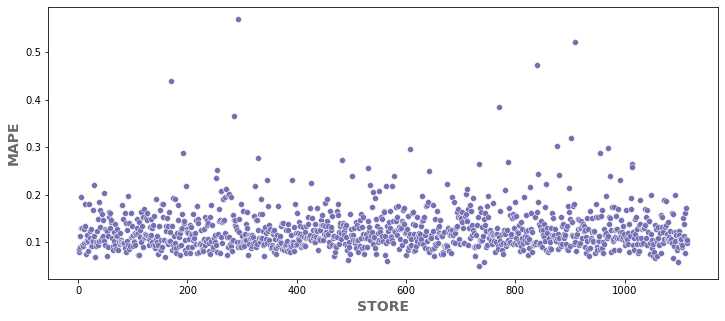

In [147]:
sns.scatterplot(x='Store', y='MAPE',
                color='#7570b3', data=df3)
plt.ylabel('MAPE', fontsize=14, color='dimgrey', fontweight='bold')
plt.xlabel('STORE', fontsize=14, color='dimgrey', fontweight='bold');

## Performance Total

In [148]:
# Somando predições, melhor cenário e pior cenário
df4 = df3[['Predictions', 'worst_scenario', 'best_scenario']].agg(
    ['sum']).T.reset_index()
df4.columns = ['Scenario', 'Values']
df4['Values'] = df4['Values'].map('R${:,.2f}'.format)
df4

,Scenario,Values
0,Predictions,"R$285,962,400.00"
1,worst_scenario,"R$285,033,662.01"
2,best_scenario,"R$285,962,551.07"


## Machine Learning Performance

In [149]:
df2['Error'] = df2['Sales'] - df2['Predictions']
df2['ErrorRate'] = df2['Predictions'] / df2['Sales']

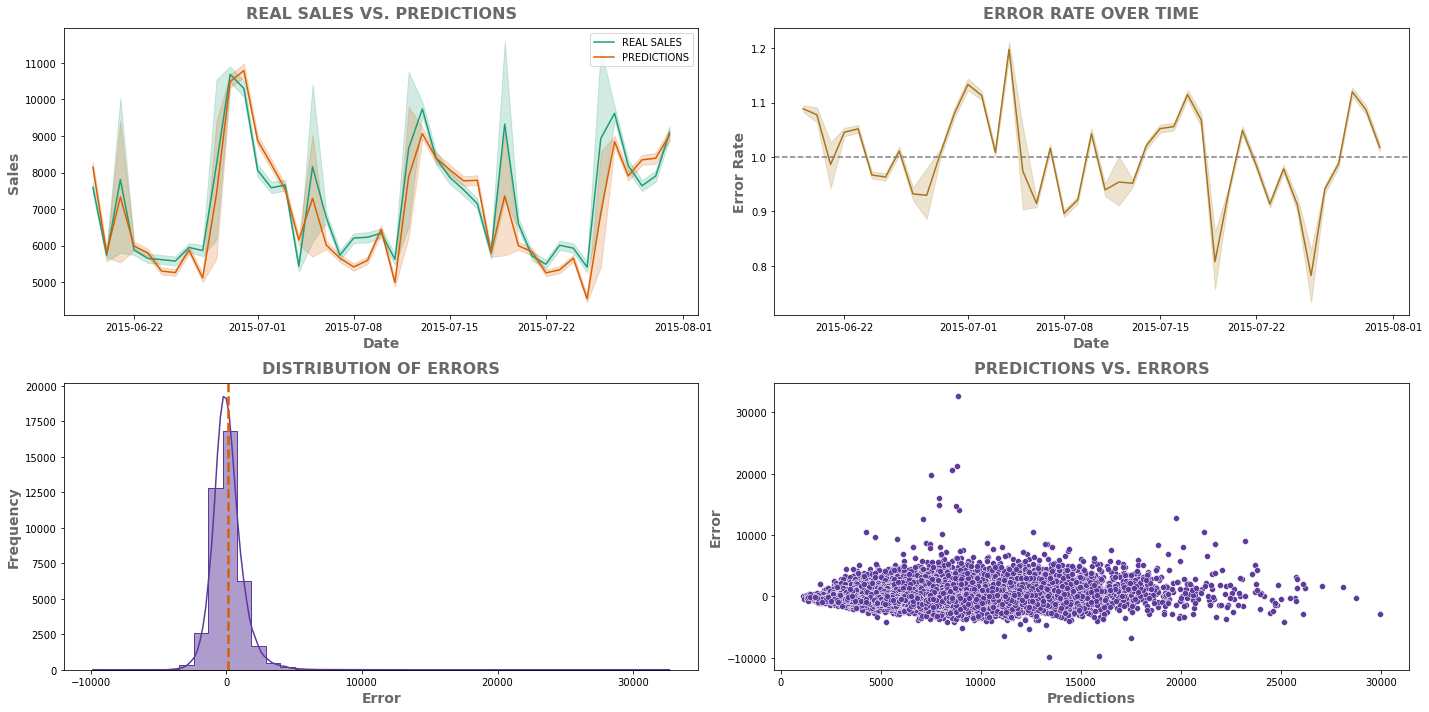

In [165]:
plt.figure(figsize=(20, 10))
sns.set_palette('colorblind')

plt.subplot(2, 2, 1)
sns.lineplot(x='Date', y='Sales', data=df2,
             label='REAL SALES', color='#1b9e77')
sns.lineplot(x='Date', y='Predictions', data=df2,
             label='PREDICTIONS', color='#d95f02')
plt.xlabel('Date', fontsize=14, color='dimgrey', fontweight='bold')
plt.ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
plt.title('REAL SALES VS. PREDICTIONS', pad=10,
          fontsize=16, color='dimgrey', fontweight='bold')
plt.legend()

plt.subplot(2, 2, 2)
sns.lineplot(x='Date', y='ErrorRate', data=df2,
             color='#a6761d')
plt.axhline(1, linestyle='--', color='gray')
plt.xlabel('Date', fontsize=14, color='dimgrey', fontweight='bold')
plt.ylabel('Error Rate', fontsize=14, color='dimgrey', fontweight='bold')
plt.title('ERROR RATE OVER TIME', pad=10,
          fontsize=16, color='dimgrey', fontweight='bold')

plt.subplot(2, 2, 3)
sns.histplot(df2['Error'], kde=True, bins=40, element='step', color='#5D3A9B')
plt.axvline(x=df2.Error.mean(), label='MEAN', color='#d95f02', ls='--', lw=2.5)
plt.xlabel('Error', fontsize=14, color='dimgrey', fontweight='bold')
plt.ylabel('Frequency', fontsize=14, color='dimgrey', fontweight='bold')
plt.title('DISTRIBUTION OF ERRORS', pad=10,
          fontsize=16, color='dimgrey', fontweight='bold')

plt.subplot(2, 2, 4)
sns.scatterplot(x='Predictions', y='Error', data=df2, color='#5D3A9B')
plt.xlabel('Predictions', fontsize=14, color='dimgrey', fontweight='bold')
plt.ylabel('Error', fontsize=14, color='dimgrey', fontweight='bold')
plt.title('PREDICTIONS VS. ERRORS', pad=10,
          fontsize=16, color='dimgrey', fontweight='bold')
plt.tight_layout()